# ゴールド

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
start = datetime(1900, 1, 1)
end = datetime(2024, 12, 9)
df = data.DataReader('gold', 'stooq', start, end)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10034 entries, 2024-12-09 to 1985-02-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    10034 non-null  float64
 1   High    10034 non-null  float64
 2   Low     10034 non-null  float64
 3   Close   10034 non-null  float64
 4   Volume  10034 non-null  float64
dtypes: float64(5)
memory usage: 470.3 KB


In [5]:
df.index.min(), df.index.max()

(Timestamp('1985-02-04 00:00:00'), Timestamp('2024-12-09 00:00:00'))

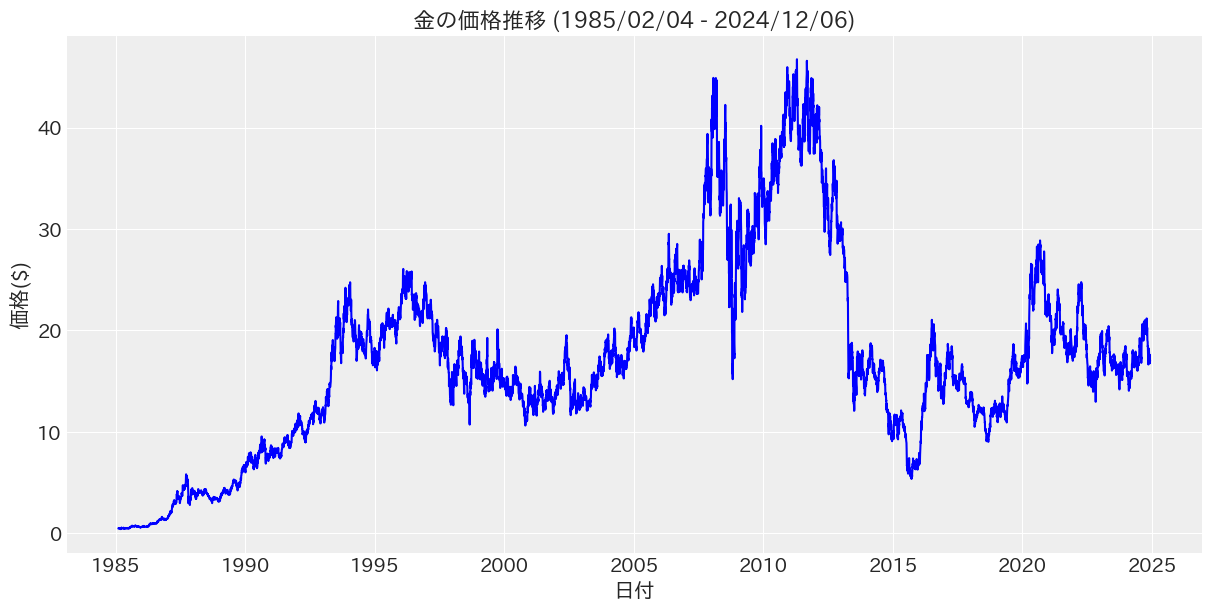

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df['Close'], color='blue')
plt.title('金の価格推移 (1985/02/04 - 2024/12/06)')
plt.ylabel('価格($)')
plt.xlabel('日付')
plt.show()

## 正規分布

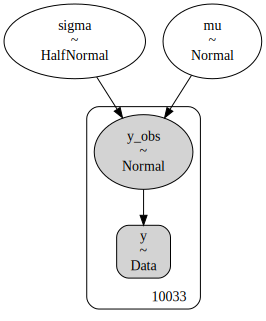

In [10]:
df['log_return'] = np.log(df['Close']).diff()

with pm.Model() as model:
    # data
    y = pm.Data('y', df['log_return'].dropna().values)

    # prior
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=0.01)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model)

In [12]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        random_seed=0,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y_obs]


Output()

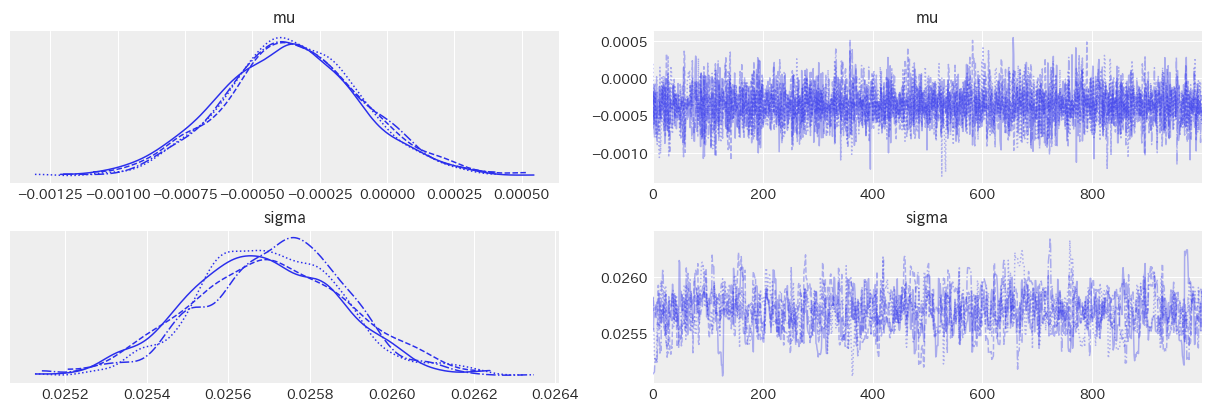

In [16]:
az.plot_trace(trace);

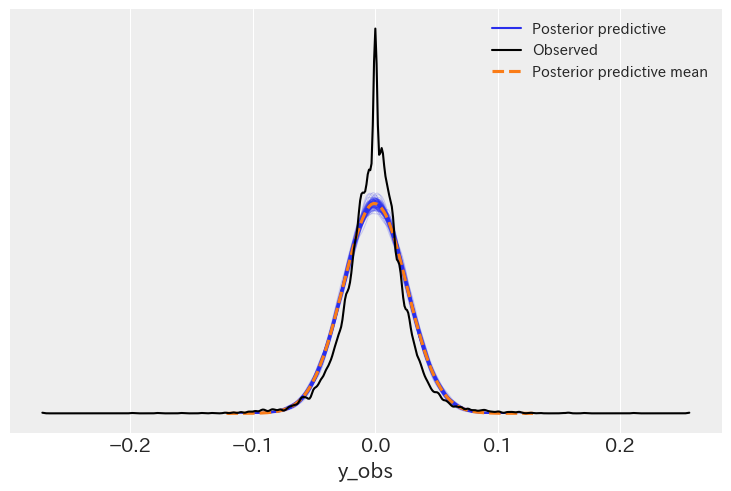

In [17]:
az.plot_ppc(trace, num_pp_samples=100);

## $t$分布

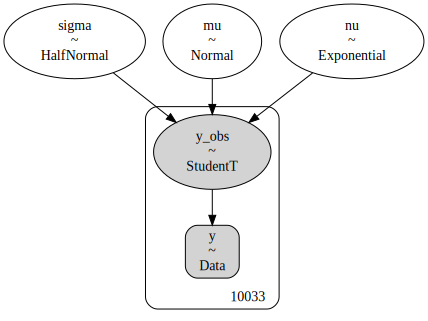

In [20]:
with pm.Model() as t_model:
    # data
    y = pm.Data('y', df['log_return'].dropna().values)

    # prior
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=0.01)
    nu = pm.Exponential('nu', lam=1/10)
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=y)

pm.model_to_graphviz(t_model)

In [21]:
with t_model:
    t_trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        random_seed=0,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
with t_model:
    pm.sample_posterior_predictive(t_trace, extend_inferencedata=True)

Sampling: [y_obs]


Output()

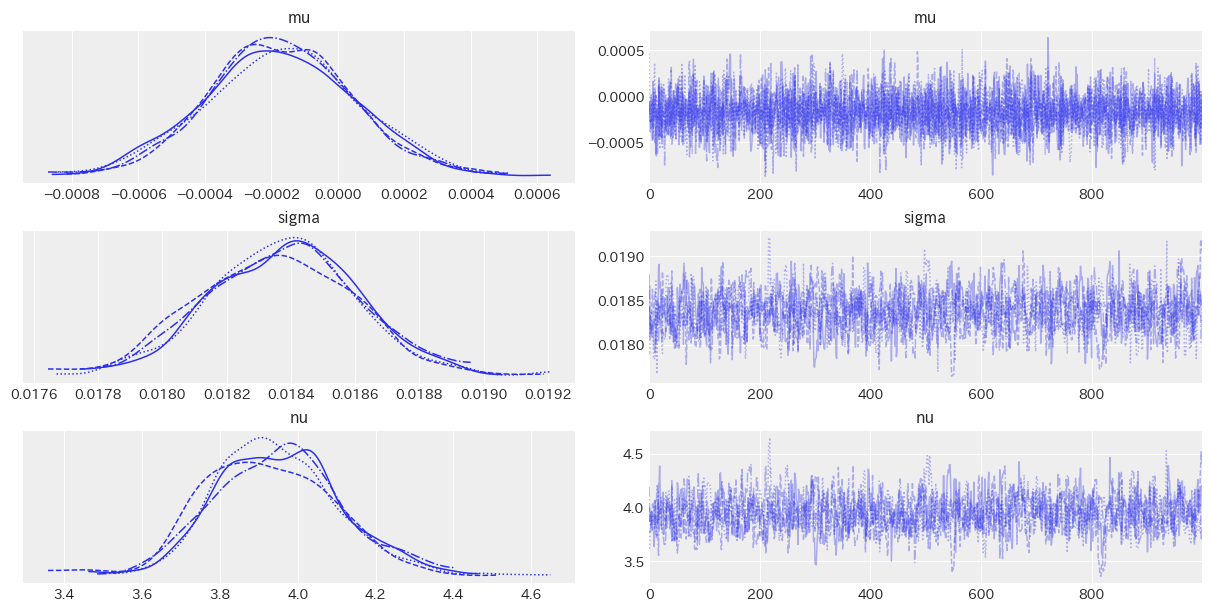

In [23]:
az.plot_trace(t_trace);

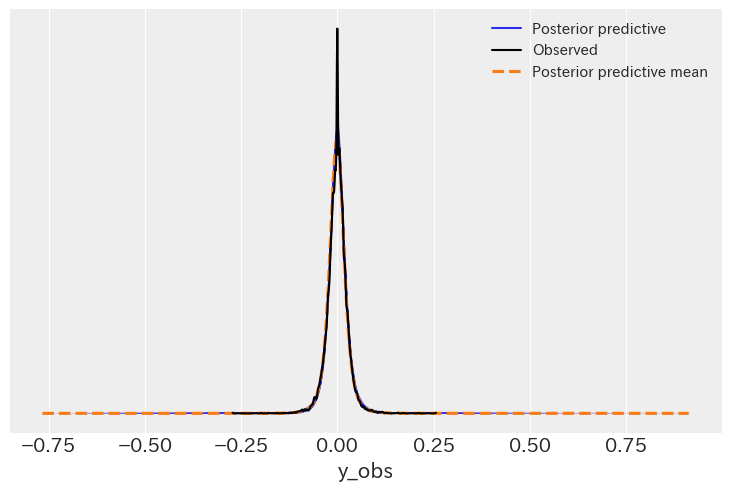

In [24]:
az.plot_ppc(t_trace, num_pp_samples=100);

## サンプリングの保存

In [ ]:
# az.to_netcdf(trace, './mcmc_samples/gold_trace_normal.nc')
# az.to_netcdf(t_trace, './mcmc_samples/gold_trace_t.nc')

'./mcmc_samples/gold_trace_t.nc'

: 